<h1>Covariance Parameter Plots</h1>

In [132]:
#Script to create plots from mean and anomaly data

import numpy as np
from tqdm import tqdm
import xarray as xr
import scipy.io as sio
import cmocean as cmocean
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath                  # to draw circle for map
import cartopy                                   # to make map
import cartopy.crs as ccrs               # for map projection
import cartopy.feature as cfeature           # to add land features to map
from datetime import date               # for saving figures with today
import matplotlib.animation as animation
from PIL import Image
import math

In [133]:
#Initializing settings for plots
###### SET WHERE TO SAVE FIGURE

root = '/global/homes/k/kefalc/code/small_files/'
savepath = '/global/homes/k/kefalc/code/plots/'
#savename = 'Southern_Ocean_map_circumpolar'

###### UNIVERSAL PLOT PARAMETERS ######

#### FIGURE SIZE
fig_width  = 3   # inches
fig_height = 3   # inches

#### FONT SIZES
fontsize_large  = 8
fontsize_medium = 6
fontsize_small  = 4

#### MARKER AND LINE SIZES
markersize     = 0.25
axis_linewidth = 1
box_linewidth  = 0.5

#### PLOT COLORS
plot_facecolor          = '#E6F1F1'
overplot_label_color    = '#7B878F'
darker_label_color      = '#C9CCD4'
background_poster_color = '#14417C'
box_color               = '#FA5BBB'

##################################################################
######  Set up Southern Ocean Map  ###############################
##################################################################

def map_southern_ocean_axes_setup(
    ax:                    matplotlib.axes.Axes,
    fig:                   matplotlib.figure.Figure,
    max_latitude:          float = -30,
    add_gridlines:         bool  = True,
    color_land:            bool  = False,
    land_edgecolor:        str   = 'grey',
    land_facecolor:        str   = 'grey',
    fontsize:              float = 10,
    map_facecolor:         str   = 'white',
    coast_linewidth:       float = 0.3,
    gridlines_linewidth:   float = 0.5,
    girdlines_color:       str   = 'grey',
    gridlines_alpha:       float = 0.5,
    longitude_label_color: str   = 'grey',
    latitude_label_color:  str   = 'grey'
) -> None:
    """
    This function sets up the subplot so that it is a cartopy map of the Southern Ocean.
    returns void as the ax and figure objects are pointers not data.
    Args:
        ax  (matplotlib.axes.Axes):     The axis object to add the map to.
        fig (matplotlib.figure.Figure): The figure object for the figure in general.
        add_gridlines (bool):           Whether or not to add gridlines to the plot.
    """
    
    
    ### Limit the map to -40 degrees latitude and below.
    ax.set_extent([-180, 180, -90, max_latitude+0.6], ccrs.PlateCarree())  # set to -29.4 for map out to 30 degrees or -39.4 for map out to 40 degrees
   
    ### Tune the subplot layout
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
    
    ### Make the background of the plot white
    ax.set_facecolor(map_facecolor)

    ### Make SO plot boundary a circle
    def plot_circle_boundary() -> None:
        """
        Make SO plot boundary a circle.
        Compute a circle in axes coordinates, which we can use as a boundary for the map.
        We can pan/zoom as much as we like - the boundary will be permanently circular.
        """
        theta  = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
        verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform = ax.transAxes)

    plot_circle_boundary()


    ### Add gridlines (if True)
    if add_gridlines:
        ax.gridlines(color = girdlines_color, alpha = gridlines_alpha, linewidth = gridlines_linewidth)
        
                # specifying xlocs/ylocs yields number of meridian/parallel lines
        dmeridian = 60  # spacing for lines of meridian
        dparallel = 20  # spacing for lines of parallel -- can change this to 10
        num_merid = int(360/dmeridian + 1)
        num_parra = int(180/dparallel + 1)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                          xlocs=np.linspace(-180, 180, num_merid), 
                          ylocs=np.linspace(-90, 90, num_parra), 
                          linestyle="-", linewidth=0.5, color='grey', alpha=gridlines_alpha)
        
        # for label alignment
        va = 'center' # also bottom, top
        ha = 'center' # right, left
        degree_symbol = u'\u00B0'

        # for locations of (meridional/longitude) labels
        lond = np.linspace(-180, 180, num_merid)
        latd = np.zeros(len(lond))

        for (alon, alat) in zip(lond, latd):
            projx1, projy1 = ax.projection.transform_point(alon, max_latitude+1, ccrs.Geodetic())  # set to -29 for map out to 30 degrees or -39 for a map out to 40 degrees
            if alon>-180 and alon<0:
                ha = 'right'
                va = 'center'
            if alon>0 and alon<180:
                ha = 'left'
                va = 'center'
            if np.abs(alon-0)<0.01:
                ha = 'center'
                va = 'bottom'
            if alon==-180:
                ha = 'center'
                va = 'top'
            if (alon<180):
                txt =  ' {0} '.format(str(int(alon)))+degree_symbol
                ax.text(projx1, projy1, txt, va=va, ha=ha, color=latitude_label_color, fontsize=fontsize)
                
        # for locations of (meridional/longitude) labels select longitude: 315 for label positioning
        lond2 = 60*np.ones(len(lond))
        latd2 = np.linspace(-90, 90, num_parra)
        va, ha = 'center', 'center'
        for (alon, alat) in zip(lond2, latd2):
            projx1, projy1 = ax.projection.transform_point(alon, alat, ccrs.Geodetic())
            txt =  ' {0} '.format(str(int(alat)))+degree_symbol
            ax.text(projx1, projy1, txt, va=va, ha=ha, color=longitude_label_color, fontsize=fontsize) 
        
        
    ### Add in coastlines/features
    if color_land:
        ax.add_feature(cfeature.LAND, zorder=0, linewidth = coast_linewidth, edgecolor=land_edgecolor, facecolor=land_facecolor)
    else:
        ax.coastlines(resolution = "50m", linewidth = coast_linewidth)

In [45]:
plevel = 3
Nblocks = 1
#nu = 32
window_size_covparam = 707
covparamfile = '/global/homes/k/kefalc/code/covar_files/oxygencovparam_ws707_N1__plevel3_dates16436.0_17531.0_test0_LBFGS.nc'
TS_gridanom = '/global/homes/k/kefalc/code/covar_files/oxygengrid_anom_ws707_N1_nu32_plevel3.nc'

<h2> Covariance Parameter </h2>

In [29]:
cds = xr.open_dataset(covparamfile)
display(cds)

<xarray.Dataset>
Dimensions:            (latitude: 21, longitude: 11, parameter: 5, pressure: 1)
Coordinates:
  * latitude           (latitude) int32 -60 -59 -58 -57 -56 ... -43 -42 -41 -40
  * longitude          (longitude) int32 -140 -139 -138 -137 ... -132 -131 -130
  * parameter          (parameter) int64 0 1 2 3 4
  * pressure           (pressure) int64 -250
Data variables:
    initial_covparam   (latitude, longitude, parameter, pressure) float64 ...
    covparam           (latitude, longitude, parameter, pressure) float64 ...
    fval               (latitude, longitude, pressure) float64 ...
    success            (latitude, longitude, pressure) float64 ...
    message            (latitude, longitude, pressure) |S50 ...
    status             (latitude, longitude, pressure) float64 ...
    nfev               (latitude, longitude, pressure) float64 ...
    nit                (latitude, longitude, pressure) float64 ...
    njev               (latitude, longitude, pressure) float64 ...
    Nblocks            (latitude, longitude, pressure) float64 ...
    Ndata_in_window    (latitude, longitude, pressure) float64 ...
    time_optimization  (latitude, longitude, pressure) float64 ...
Attributes:
    description:            For description, see https://docs.scipy.org/doc/s...
    pressureindex:          3
    window_size:            707106.7811865475
    Nblocks:                1
    nu:                     1.5
    total_time:             6.898663759231567
    residualfile:           /global/homes/k/kefalc/code/anom_files/test/resid...
    datafile:               
    initial_covparamsfile:  None
    filename:               /global/homes/k/kefalc/code/covar_files/oxygencov...
    created_date:           2025-02-21 16:12:55.310858

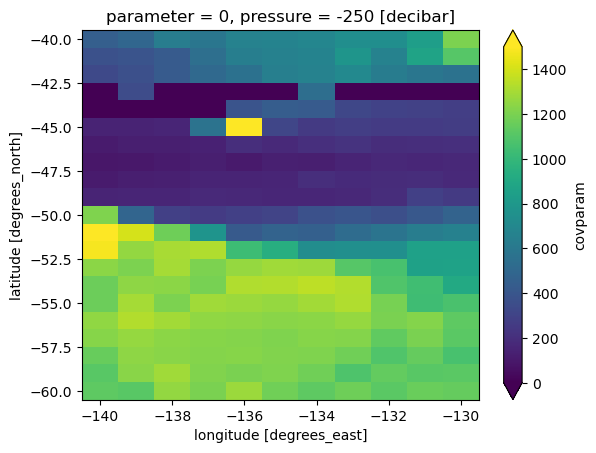

In [44]:
cds.covparam.sel(pressure=-250, parameter=0, latitude=slice(None, -20)).plot(cmap='viridis', vmin=0.0, vmax=1500)
##need var=0 or 1 for TS

<h2> Small Scale Grid </h2>

In [46]:
TSg = xr.open_dataset(TS_gridanom)
display(TSg)

<xarray.Dataset>
Dimensions:    (latitude: 21, longitude: 11, time: 109, pressure: 1)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-06 2015-01-16 ... 2017-12-21
  * latitude   (latitude) int32 -60 -59 -58 -57 -56 -55 ... -44 -43 -42 -41 -40
  * longitude  (longitude) int32 -140 -139 -138 -137 ... -133 -132 -131 -130
  * pressure   (pressure) int64 -250
Data variables:
    anom       (latitude, longitude, time, pressure) float64 ...
    mse        (latitude, longitude, time, pressure) float64 ...
Attributes:
    description:            Gridded estimated anomalies and errors on 10day grid
    pressureindex:          3
    window_size:            250
    Nblocks:                707106.7811865475
    covparamfile:           /global/homes/k/kefalc/code/covar_files/oxygencov...
    anomfile:               /global/homes/k/kefalc/code/anom_files/test/resid...
    filename:               /global/homes/k/kefalc/code/covar_files/grid_anom...
    maptime_interval_days:  10
    created_date:           2025-02-21 17:10:32.268797

<h3> Anomalies </h3>

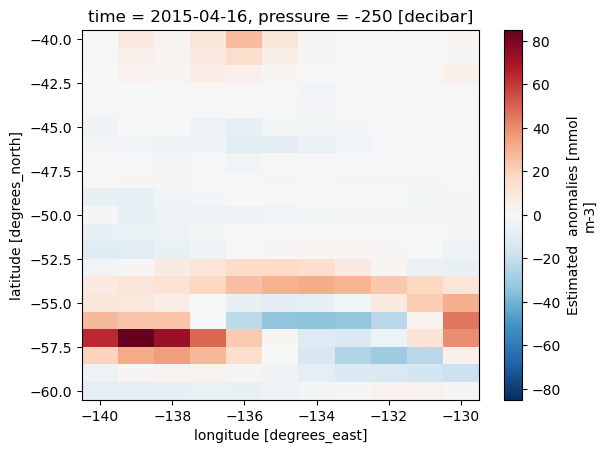

In [47]:
TSg.anom.sel(pressure=-250,latitude=slice(None, -20)).isel(time=10).plot(cmap='RdBu_r')#,vmin=-1.67, vmax=1.67)
#need var= 0 or 1 for TS
plt.savefig(savepath + 'GridSynth_Sal_Anom_250db_2015_2017.png')

<h3> Mean Squared Error </h3>

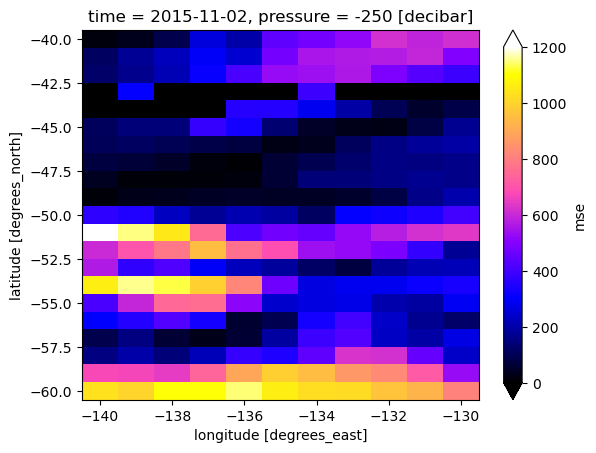

In [49]:
TSg.mse.sel( pressure=-250,latitude=slice(None, -20)).isel(time=30).plot(cmap='gnuplot2', vmin=0, vmax=1200)
#need var = 0 or 1 for TS

In [ ]:
january 0:7
february 7:13
march 13:19
april 19:25
may 25:31
june 31:37
july 37:43
august 43:49
september 49:55
october 55:61
november 61:67
december 67:-1

In [22]:
##MSE plot
ds = xr.open_dataset('/global/homes/k/kefalc/code/gpr-mapping-covar/plevel4_S_O2_SouthernOcean.nc')
ds1 = ds.mse.sel(time=slice('2017-01-01', '2017-01-31'))
ds2 = ds1[:,-1].assign_coords(longitude = -180.5)
ds3 = xr.concat([ds2,ds1],"longitude")
mse = np.squeeze(ds3.values)
mean_mse = mse[:,:,:].mean(axis = 1)
rmse = np.sqrt(mean_mse/6)

lon  = ds3['longitude'].values
lat  = ds3['latitude'].values

import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

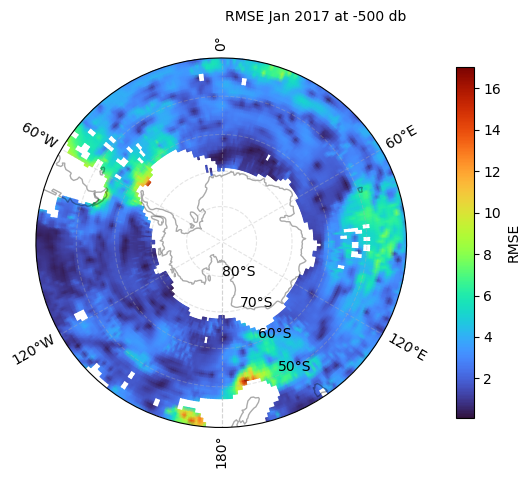

In [23]:

projection = ccrs.SouthPolarStereo()
data_crs = ccrs.PlateCarree()

fs = 10

#print(name_string)

tt = 30
#fig  = plt.figure(figsize=(18,10))
ax = plt.axes(projection=projection)
#ax.stock_img() #this fills in background with map image (blue water, white ice etc.)
ax.coastlines(alpha=0.3333)
gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
ax.set_extent([-180,180,-90, -40], crs=ccrs.PlateCarree())
ax.set_boundary(map_circle, transform=ax.transAxes)
result = plt.pcolormesh(lon,lat,rmse,cmap='turbo', transform=data_crs, shading = 'gouraud')
cbar=plt.colorbar(orientation='vertical',shrink=0.95,pad=0.1)#,ticks=cticks) #fraction=0.075, pad=0.15,shrink=1.0
cbar.set_label('RMSE',fontsize=10)
plt.xlabel('Longitude in °E',fontsize=fs)
plt.ylabel('Latitude in °N',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

#cbar.ax.set_xticklabels(cticks_label)
plt.annotate(('RMSE Jan ' + str(2017)) + ' at ' + str(-500) + ' db',xy=(1.0,1.1),
             xycoords='axes fraction',fontsize=10,ha='right')
#plt.annotate('time step '+str(tt+1),xy=(0.99,1.015),\
#                     xycoords='axes fraction',fontsize=fs,ha='right')#,color='k',fontweight='bold')
#plt.show()
plt.savefig(savepath + 'RMSE_Oxy_with_S_500db_Jan17.png')

In [10]:
min(rmse.flatten())

0.5399033530747955

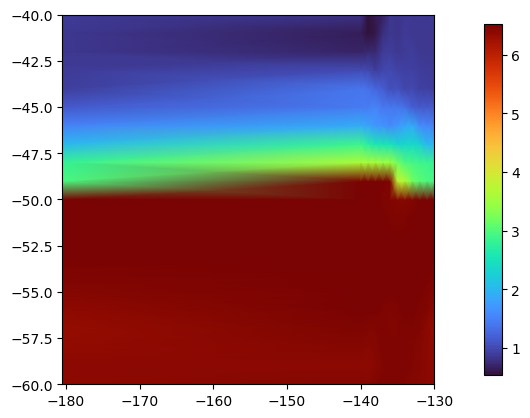

In [5]:
##MSE plot
ds = xr.open_dataset('/global/homes/k/kefalc/code/covar_files/Tests/oxygen_grid_anom_ws989_N1_plevel4_dates17167.0_17531.0_mvf2_param1_test0.nc')
ds1 = ds.mse[:,:,0:7]
ds2 = ds1[:,-1].assign_coords(longitude = -180.5)
ds3 = xr.concat([ds2,ds1],"longitude")
mse = np.squeeze(ds3.values)
mean_mse = mse[:,:,:].mean(axis = 1)
rmse = np.sqrt(mean_mse/6)

lon  = ds3['longitude'].values
lat  = ds3['latitude'].values

result = plt.pcolormesh(lon,lat,rmse,cmap='turbo', shading = 'gouraud')
cbar=plt.colorbar(orientation='vertical',shrink=0.95,pad=0.1)#,ticks=cticks)

In [126]:
##Covar plot
#beta, lengthscales, rho
#rho is correlation between noise signals
ds = xr.open_dataset('/global/homes/k/kefalc/code/gpr-mapping-covar/plevel4_T_O2_SouthernOcean.nc')
ds1 = ds.lengthscale[:,:,2]
ds2 = ds1[:,-1].assign_coords(longitude = -180)
ds3 = xr.concat([ds2,ds1],"longitude")
covparam = np.squeeze(ds3.values)
display(covparam)

lon  = ds3['longitude'].values
lat  = ds3['latitude'].values

import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [128]:
##estimated noise
ds = xr.open_dataset('/global/homes/k/kefalc/code/gpr-mapping-covar/plevel4_T_O2_SouthernOcean.nc')
ds1 = ds.noise
ds2 = ds1[:,-1].assign_coords(longitude = -180)
ds3 = xr.concat([ds2,ds1],"longitude")
covparam = np.squeeze(ds3.values)
covparam = np.sqrt(covparam)
display(covparam)

lon  = ds3['longitude'].values
lat  = ds3['latitude'].values

import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [130]:
#estimated std dev
ds = xr.open_dataset('/global/homes/k/kefalc/code/gpr-mapping-covar/plevel4_T_O2_SouthernOcean.nc')
ds1 = ds.sigmasq
ds2 =  np.sqrt((np.pi/2)**2*ds1/(ds.lengthscale[:,:,0] * ds.lengthscale[:,:,1] * ds.lengthscale[:,:,2]))
ds3 = ds2[:,-1].assign_coords(longitude = -180)
ds4 = xr.concat([ds3,ds2],"longitude")
covparam = np.squeeze(ds4.values)

display(covparam.shape)

lon  = ds4['longitude'].values
lat  = ds4['latitude'].values

import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

(42, 361)

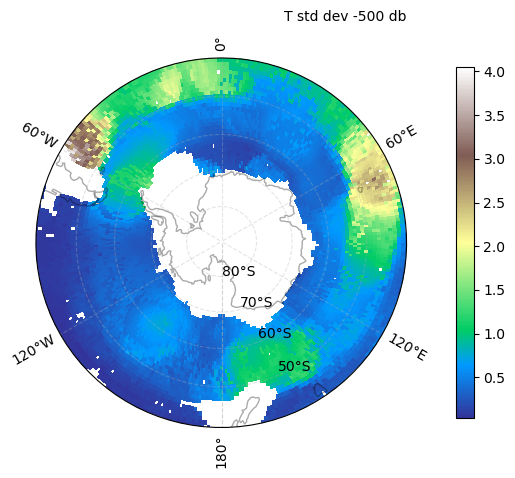

In [131]:
projection = ccrs.SouthPolarStereo()
data_crs = ccrs.PlateCarree()

fs = 10

#print(name_string)

tt = 30
#fig  = plt.figure(figsize=(18,10))
ax = plt.axes(projection=projection)
#ax.stock_img() #this fills in background with map image (blue water, white ice etc.)
ax.coastlines(alpha=0.3333)
gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
ax.set_extent([-180,180,-90, -40], crs=ccrs.PlateCarree())
ax.set_boundary(map_circle, transform=ax.transAxes)
result = plt.pcolormesh(lon,lat,covparam,cmap='terrain', transform=data_crs)#, vmin = 0, vmax =500, shading = 'gouraud')
cbar=plt.colorbar(orientation='vertical',shrink=0.95,pad=0.1)#,ticks=cticks) #fract-on=0.075, pad=0.15,shrink=1.0
#cbar.set_label('difference interpolated oxygen in mmol m-3',fontsize=10)
plt.xlabel('Longitude in °E',fontsize=fs)
plt.ylabel('Latitude in °N',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

#cbar.ax.set_xticklabels(cticks_label)
plt.annotate(('T std dev ' + str(-500) + ' db'), xy=(1.0,1.1),
             xycoords='axes fraction',fontsize=10,ha='right')
#plt.annotate('time step '+str(tt+1),xy=(0.99,1.015),\
#                     xycoords='axes fraction',fontsize=fs,ha='right')#,color='k',fontweight='bold')
#plt.show()
plt.savefig(savepath + 'std_T_500db.png')

In [3]:
##correlation coefficients Temperature
bs = xr.open_dataset('/global/homes/k/kefalc/code/anom_files/final/oxy/res/residualfile_plevel4oxygen_dates16436.0_18261.0_test0.nc')
ts = xr.open_dataset('/global/homes/k/kefalc/code/anom_files/final/TS/res/residualfile_plevel4_dates16436.0_18261.0_test0.nc')

bres = bs.residuals_bgc.to_numpy()[:]
tres = ts.residuals_temp.to_numpy()[:]
sres = ts.residuals_sal.to_numpy()[:]


In [ ]:
##Correlation coefficients Salinity